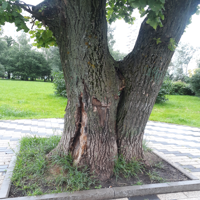

In [14]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Загрузка изображения ---
image = Image.open('images/tree.jpg').convert("RGB")
image = image.resize((200, 200)).rotate(-90)
image

In [15]:
torch.cuda.is_available()

True

In [16]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# --- 1. Загрузка SAM ---
sam_checkpoint = "sam_vit_h_4b8939.pth"  # скачай заранее
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
sam.to(device)
mask_generator = SamAutomaticMaskGenerator(sam)

# --- 2. Загружаем картинку ---
image_np = np.array(image)

# --- 3. Генерация масок ---
masks = mask_generator.generate(image_np)

# Выбираем самую большую маску (обычно это дерево)
mask_areas = [np.sum(m["segmentation"]) for m in masks]
largest_mask_idx = np.argmax(mask_areas)
mask = masks[largest_mask_idx]["segmentation"]

# --- 4. Применяем маску ---
masked_img = image_np.copy()
masked_img[~mask] = 255
masked_pil = Image.fromarray(masked_img)

In [28]:
import json

with open('tree_class.json', 'r') as trees:
    data = json.load(trees)

In [29]:
import open_clip

# --- 1. Загружаем модель BioCLIP ---
model_clip, preprocess, _ = open_clip.create_model_and_transforms(
    'hf-hub:imageomics/bioclip'
)
tokenizer = open_clip.get_tokenizer('hf-hub:imageomics/bioclip')

device = "cuda" if torch.cuda.is_available() else "cpu"
model_clip = model_clip.to(device).eval()

# --- 2. Классы (замени на свои) ---
classes = list(data.keys())

# --- 3. Подготовка текстов ---
text_tokens = tokenizer(classes).to(device)

# --- 4. Подготовка изображения ---
image_tensor = preprocess(masked_pil).unsqueeze(0).to(device)

# --- 5. Получение эмбеддингов ---
with torch.no_grad():
    image_features = model_clip.encode_image(image_tensor)
    text_features = model_clip.encode_text(text_tokens)

    # Нормализация
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Сходство
    logits_per_image = 100.0 * image_features @ text_features.T
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()[0]

Silver Birch   : 0.599
Horse Chestnut : 0.034
Small-leaved Lime: 0.002
Norway Maple   : 0.036
Box Elder      : 0.000
Rowan          : 0.315
English Oak    : 0.015

Predicted: Silver Birch


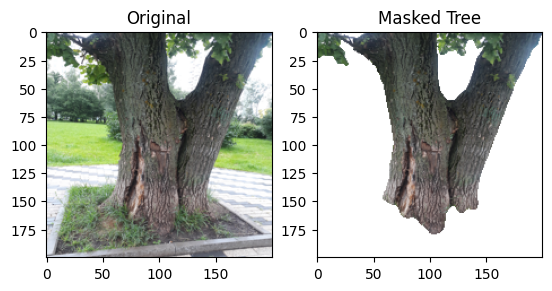

In [30]:
# --- 4. Вывод результата ---
for cls, p in zip(classes, probs):
    print(f"{cls:15s}: {p:.3f}")

print("\nPredicted:", classes[int(probs.argmax())])

# Визуализация
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(masked_pil)
plt.title("Masked Tree")
plt.show()
